In [ ]:
# TO DO: Auto load in multiple datasets

In [ ]:
! pip install --upgrade matplotlib

In [40]:
# Library Imports

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import matplotlib.pyplot as plt

In [12]:
# Import the dataset

dataset = pd.read_csv('stock_data/AMZN.csv')
dataset = dataset[['Open', 'High', 'Low', 'Close']]

# Feature Engineering 

dataset['H-L'] = dataset['High'] - dataset['Low']
dataset['O-C'] = dataset['Close'] - dataset['Open']
dataset['3day MA'] = dataset['Close'].shift(1).rolling(window = 3).mean()
dataset['10day MA'] = dataset['Close'].shift(1).rolling(window = 10).mean()
dataset['30day MA'] = dataset['Close'].shift(1).rolling(window = 30).mean()
dataset['Std_dev']= dataset['Close'].rolling(5).std()


In [13]:
'''
Identify price rises. Using a binary variable, 1, to indicate when
the closing price of the next day is greater than the closing price of prior day.
'''

dataset['Price_Rise'] = np.where(dataset['Close'].shift(-1) > dataset['Close'], 1, 0)

In [19]:
# Drop NAN values

dataset = dataset.dropna()

dataset.head()

,Open,High,Low,Close,H-L,O-C,3day MA,10day MA,30day MA,Std_dev,Price_Rise
30,36.209999,36.450001,35.750000,36.139999,0.700001,-0.070000,35.863332,37.130000,40.616666,0.158524,0
31,35.930000,36.349998,35.580002,35.660000,0.769996,-0.270000,35.983332,36.496000,40.337333,0.199047,1
32,35.740002,35.849998,35.250000,35.689999,0.599998,-0.050003,35.943333,35.873999,40.121333,0.213658,0
33,35.610001,35.750000,35.099998,35.310001,0.650002,-0.300000,35.829999,35.867999,39.918666,0.329590,0
34,35.020000,35.389999,34.509998,34.720001,0.880001,-0.299999,35.553333,35.826999,39.727333,0.528137,0


In [20]:
# Seperate target variable and drop target variable from df

df = dataset.drop('Price_Rise', axis=1)
y = dataset['Price_Rise']

In [22]:
# Split the Dataset

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.20, 
                                                    random_state=42)

In [29]:
'''
Establish a Baseline & Domain Knowledge:

We need to accomplish a better accuracy % then our baseline of 52.1 pct. 
Why such a low baseline? Casino's make their money with 51%/49% odds. Any rate
better then a 51% accuracy rate should be considered as a success.
'''

y_train.value_counts(normalize=True)

1    0.521159
0    0.478841
Name: Price_Rise, dtype: float64

In [33]:
'''
Feature Scaling and Standardizing:

This ensures that there is no bias while training the model due to the 
different scales of all input features. If this is not done the neural 
network might get confused and give a higher weight to those features 
which have a higher average value than others.
'''

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
'''
NN Notes:

Units: This defines the number of nodes or neurons in that particular layer. 
We have set this value to 128, meaning there will be 128 neurons in our hidden layer.

Kernel_initializer: This defines the starting values for the weights of the 
different neurons in the hidden layer. We have defined this to be ‘uniform’, 
which means that the weights will be initialized with values from a uniform distribution.

Activation: This is the activation function for the neurons in the particular hidden layer. 
Here we define the function as the rectified Linear Unit function or ‘relu’.

Inputs: This defines the number of inputs to the hidden layer, we have defined this 
value to be equal to the number of columns of our input feature dataframe. 
This argument will not be required in the subsequent layers, as the model will know 
how many outputs the previous layer produced.
'''

In [34]:
'''
Variables for NN - Adjust as neccessary. 
'''
epochs = 100
batch_size = 10
inputs = X_train.shape[1]

In [37]:
'''
Building the NN
'''

model = Sequential()

# Two Hidden Layers

model.add(Dense(128, kernel_initializer='uniform', activation='relu', input_shape=(inputs,)))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))

# Output Layer

model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

# Compile the Model

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['acc'])

In [ ]:
# Fit and Train Model

model.fit(X_train, y_train, 
          batch_size = batch_size, 
          epochs = epochs)

In [ ]:
# To DO: hyperparameter tuning

In [42]:
'''
Predict the Movement of Stock:

Now that the neural network has been compiled, we can use the predict() method for making the prediction. 
We pass X_test as its argument and store the result in a variable named ypred. 
We then convert ypred to store binary values by storing the condition ypred > 5. 
Now, the variable y_pred stores either True or False depending on whether the 
predicted value was greater or less than 0.5.
'''

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

In [43]:
'''
Next, we create a new column in the dataframe dataset with the column header ‘ypred’ 
and store NaN values in the column. 
We then store the values of ypred into this new column, starting from the rows of the test dataset. 
This is done by slicing the dataframe using the iloc method as shown in the code below. 
We then drop all the NaN values from the dataset and store them in a new dataframe named trade_dataset.
'''

dataset['y_pred'] = np.NaN
dataset.iloc[(len(dataset) - len(y_pred)):,-1:] = y_pred
trade_dataset = dataset.dropna()

In [ ]:
# Computing Strategy Returns

trade_dataset['Tomorrows Returns'] = 0.
trade_dataset['Tomorrows Returns'] = np.log(trade_dataset['Close']/trade_dataset['Close'].shift(1))
trade_dataset['Tomorrows Returns'] = trade_dataset['Tomorrows Returns'].shift(-1)

In [ ]:
trade_dataset['Strategy Returns'] = 0.
trade_dataset['Strategy Returns'] = np.where(trade_dataset['y_pred'] == True, trade_dataset['Tomorrows Returns'], - trade_dataset['Tomorrows Returns'])

In [ ]:
trade_dataset['Cumulative Market Returns'] = np.cumsum(trade_dataset['Tomorrows Returns'])
trade_dataset['Cumulative Strategy Returns'] = np.cumsum(trade_dataset['Strategy Returns'])

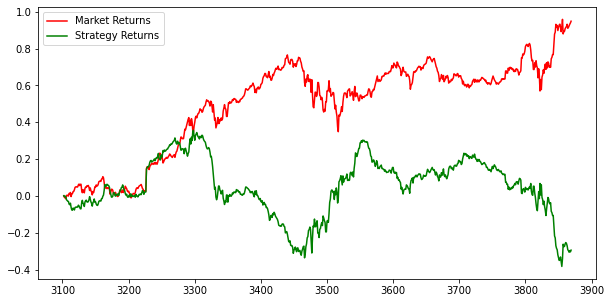

In [49]:
# Graph Our Results

plt.figure(figsize=(10,5))
plt.plot(trade_dataset['Cumulative Market Returns'], color='r', label='Market Returns')
plt.plot(trade_dataset['Cumulative Strategy Returns'], color='g', label='Strategy Returns')
plt.legend()
plt.show()

In [ ]:
# To Do: Try hyperparameter tuning for better results. 

# Consider: Gather more data points (+100,000) for a more accurate model